In [5]:
import sys, os
from pyprojroot import here


# spyder up to find the root
local = here(project_files=[".local"])

# append to path
sys.path.append(str(local))

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
import xarray as xr
import flax
import imageio
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import equinox as eq

from src.utils import get_meshgrid

%load_ext autoreload
%autoreload 2

In [2]:
# Load image, take a square crop from the center
# image_url = "https://github.com/AntonBaumannDE/fourier_features_MLP_tf2/raw/main/images/monkey.jpg"
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]


losses = {}

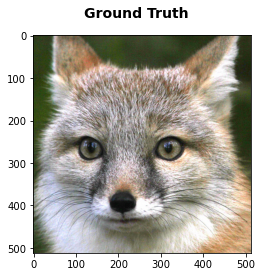

In [3]:
fig = plt.figure()
fig.suptitle('Ground Truth', fontsize=14, fontweight='bold')
plt.imshow(img)
plt.show()

In [29]:
# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
factor = 8
train_data = [x_test[::factor,::factor], img[::factor,::factor]]

In [30]:
train_data[0].shape, train_data[0].shape, test_data[0].shape, test_data[0].shape

((64, 64, 2), (64, 64, 2), (512, 512, 2), (512, 512, 2))

In [31]:
from flax import linen as nn

class MLP(nn.Module):
    """A simple MLP model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=3)(x)
        x = nn.sigmoid(x)
        return x

In [32]:


# initialize model
model = MLP()
# get demo data
batch = train_data[0]

variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)

In [33]:

# assert features.shape == (batch.shape[0],batch.shape[1],mapping_size*2)

In [34]:
# Same as JAX version but using model.apply().
# def mse(params, x_batched, y_batched):
#     # Define the squared loss for a single pair (x,y)
#     def squared_error(x, y):
#         pred = model.apply(params, x)
#         return jnp.inner(y-pred, y-pred) / 2.0
#     # Vectorize the previous to compute the average of the loss on all samples.
#     return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)


def mse(params, x, y):
    
    # error
    diff = model.apply(params, x) - y
    
    # mean squared error
    return jnp.mean(diff ** 2)

In [35]:
import optax
alpha = 1e-4
tx = optax.adam(learning_rate=alpha)
opt_state = tx.init(variables)
loss_grad_fn = jax.jit(jax.value_and_grad(mse))

In [36]:
loss, grad = loss_grad_fn(variables, train_data[0], train_data[1])

In [37]:
losses["mlp"] = []
iterations = 2_000

with tqdm.trange(iterations) as pbar:
    for i in pbar:
        loss_val, grads = loss_grad_fn(variables, train_data[0], train_data[1])
        updates, opt_state = tx.update(grads, opt_state)
        variables = optax.apply_updates(variables, updates)
        pbar.set_description(f'Loss step {i}: {loss_val:.4f}')
        losses["mlp"].append(loss_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

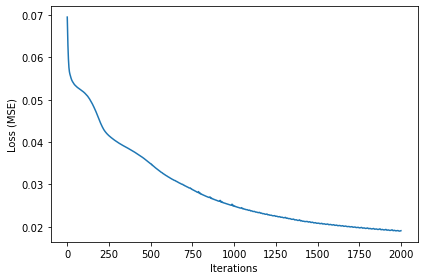

In [38]:
fig, ax = plt.subplots()

ax.plot(losses["mlp"])
ax.set(xlabel="Iterations", ylabel="Loss (MSE)")
plt.tight_layout()
plt.show()

In [39]:
outputs = model.apply(variables, train_data[0])

In [40]:
train_data[0].shape

(64, 64, 2)

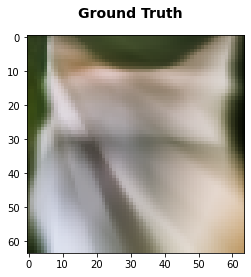

In [41]:
fig = plt.figure()
fig.suptitle('Ground Truth', fontsize=14, fontweight='bold')
plt.imshow(outputs)
plt.show()

## Fourier Features

In [65]:
# Fourier feature mapping
def input_mapping(x, B): 
    if B is None:
        return x
    else:
        x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [75]:
rand_key = jax.random.PRNGKey(123)
mapping_size = 1028
scale = 10

# generate random features
B = jax.random.normal(rand_key, (mapping_size, 2))
B *= scale

# transform to features
batch = train_data[0]
features = input_mapping(batch, B)

# check shape
features.shape

(64, 64, 2056)

In [76]:

# initialize model
model = MLP()
# get demo data

variables = model.init(jax.random.PRNGKey(0), features)
output = model.apply(variables, features)

In [77]:
import optax
alpha = 1e-4
tx = optax.adam(learning_rate=alpha)
opt_state = tx.init(variables)
loss_grad_fn = jax.jit(jax.value_and_grad(mse))

In [78]:
losses["rff"] = []
iterations = 2_000

with tqdm.trange(iterations) as pbar:
    for i in pbar:
        loss_val, grads = loss_grad_fn(variables, features, train_data[1])
        updates, opt_state = tx.update(grads, opt_state)
        variables = optax.apply_updates(variables, updates)
        pbar.set_description(f'Loss step {i}: {loss_val:.3e}')
        losses["rff"].append(loss_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

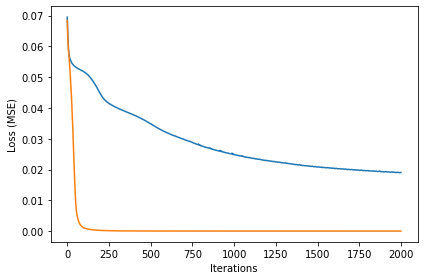

In [79]:
fig, ax = plt.subplots()

ax.plot(losses["mlp"])
ax.plot(losses["rff"])
ax.set(xlabel="Iterations", ylabel="Loss (MSE)")
plt.tight_layout()
plt.show()

In [82]:
# features = input_mapping(train_data[0], B)
features = input_mapping(x_test, B)
outputs = model.apply(variables, features)

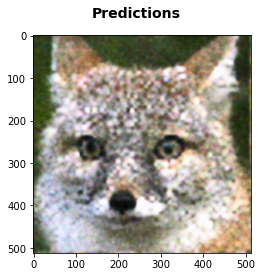

In [83]:
fig = plt.figure()
fig.suptitle('Predictions', fontsize=14, fontweight='bold')
plt.imshow(outputs)
plt.show()

In [73]:
batch.shape, features.shape

((64, 64, 2), (512, 512, 512))